In [53]:
import matplotlib.pyplot as plt
import statsmodels.api as sms
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import numpy as np

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn
import seaborn as sns

In [54]:
data = pd.read_csv('./London_property1.csv')

In [55]:
data.dropna(how='any', inplace=True)
data.drop_duplicates(inplace=True, keep='first', subset='id')

In [56]:
    for index, row in data.iterrows():
        
        # clean the dataset 
        if row['priceper'] < 1000 or row['priceper'] > 30000 or row['price'] == 0 or row['CONSTRUCTION_AGE_BAND']=='INVALID!':
            data.drop(index=index, inplace=True)
            continue

In [57]:
df = data[['Code','Area_name','priceper','propertytype','duration','price','tfarea',
          'numberrooms','classt','CURRENT_ENERGY_EFFICIENCY','POTENTIAL_ENERGY_EFFICIENCY']]

In [58]:
df.head(10)

,Code,Area_name,priceper,propertytype,duration,price,tfarea,numberrooms,classt,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY
1,E09000015,Harrow,1024.390244,S,F,210000,205.0,8.0,11,57,76
2,E09000017,Hillingdon,1027.173913,T,F,94500,92.0,5.0,12,69,86
3,E09000008,Croydon,1061.946903,F,L,120000,113.0,5.0,11,68,78
7,E09000004,Bexley,1493.055556,T,F,215000,144.0,5.0,11,48,77
8,E09000016,Havering,1500.000000,F,L,144000,96.0,4.0,11,76,77
9,E09000004,Bexley,1500.000000,F,L,112500,75.0,3.0,11,81,83
11,E09000023,Lewisham,1728.624535,F,L,465000,269.0,3.0,11,43,58
14,E09000016,Havering,1854.545455,F,L,102000,55.0,3.0,11,79,81
15,E09000008,Croydon,1872.340426,F,L,88000,47.0,2.0,11,77,77
16,E09000026,Redbridge,1875.000000,T,F,210000,112.0,5.0,12,68,86


In [59]:
df1 = data[['Area_name','priceper','propertytype','duration','tfarea',
          'numberrooms','classt','CURRENT_ENERGY_EFFICIENCY','POTENTIAL_ENERGY_EFFICIENCY']]

In [60]:
df1['lnpriceper'] = np.log(df1.priceper)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [61]:
df1 = pd.get_dummies(df1)

In [62]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(data, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        data_with_const = add_constant(data)

        vif_data = pd.Series([variance_inflation_factor(data_with_const.values, i) 
               for i in range(data_with_const.shape[1])], name= "VIF",
              index=data_with_const.columns).to_frame()

        # drop the const
        vif_data = vif_data.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_data.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_data.index[vif_data.VIF == vif_data.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            data = data.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return data

In [63]:
# using VIF on the bike_rental dataset

data_predictors_selected_VIF = drop_column_using_vif_(df1.drop('priceper', axis=1))
# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(data_predictors_selected_VIF.columns)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping: Area_name_Barking and Dagenham
Dropping: propertytype_D
Dropping: duration_F
Dropping: propertytype_F
Dropping: duration_L
Dropping: Area_name_Bromley
The columns remaining after VIF selection are:
Index(['tfarea', 'numberrooms', 'classt', 'CURRENT_ENERGY_EFFICIENCY', 'POTENTIAL_ENERGY_EFFICIENCY', 'lnpriceper', 'Area_name_Barnet', 'Area_name_Bexley', 'Area_name_Brent', 'Area_name_Camden',
       'Area_name_City of London', 'Area_name_Croydon', 'Area_name_Ealing', 'Area_name_Enfield', 'Area_name_Greenwich', 'Area_name_Hackney', 'Area_name_Hammersmith and Fulham', 'Area_name_Haringey',
       'Area_name_Harrow', 'Area_name_Havering', 'Area_name_Hillingdon', 'Area_name_Hounslow', 'Area_name_Islington', 'Area_name_Kensington and Chelsea', 'Area_name_Kingston upon Thames',
       'Area_name_Lambeth', 'Area_name_Lewisham', 'Area_name_Merton', 'Area_name_Newham', 'Area_name_Redbridge', 'Area_name_Richmond upon Thames', 'Area_name_Southwark', 'Area_name_Sutton',
       'Area_name_To

In [91]:
X = df1[['tfarea', 'numberrooms', 'classt', 'CURRENT_ENERGY_EFFICIENCY','duration_F',
       'POTENTIAL_ENERGY_EFFICIENCY','propertytype_D', 'propertytype_T','propertytype_F',
         'Area_name_Barnet', 'Area_name_Bexley',
       'Area_name_Brent', 'Area_name_Bromley', 'Area_name_Camden',
       'Area_name_City of London', 'Area_name_Croydon', 'Area_name_Ealing',
       'Area_name_Enfield', 'Area_name_Greenwich', 'Area_name_Hackney',
       'Area_name_Hammersmith and Fulham', 'Area_name_Haringey',
       'Area_name_Harrow', 'Area_name_Havering', 'Area_name_Hillingdon',
       'Area_name_Hounslow', 'Area_name_Islington',
       'Area_name_Kensington and Chelsea', 'Area_name_Kingston upon Thames',
       'Area_name_Lambeth', 'Area_name_Lewisham', 'Area_name_Merton',
       'Area_name_Newham', 'Area_name_Redbridge',
       'Area_name_Richmond upon Thames', 'Area_name_Southwark',
       'Area_name_Sutton', 'Area_name_Tower Hamlets',
       'Area_name_Waltham Forest', 'Area_name_Wandsworth',
       'Area_name_Westminster']]
regression_model = sm.OLS(endog= df1['priceper'], exog=sm.add_constant(X)).fit()
regression_model.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               priceper   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     127.0
Date:                Sat, 08 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:13:47   Log-Likelihood:                -41896.
No. Observations:                4667   AIC:                         8.388e+04
Df Residuals:                    4625   BIC:                         8.415e+04
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                             5368.8596    812.331      6.609      0.000    3776.303    6961.416
tfarea                              -3.2489      0.934     -3.478      0.001      -5.080      -1.418
numberrooms                        -74.5369     23.026     -3.237      0.001    -119.678     -29.396
classt                             110.5746     62.371      1.773      0.076     -11.702     232.851
CURRENT_ENERGY_EFFICIENCY           -9.3430      3.286     -2.844      0.004     -15.785      -2.901
duration_F                         298.3995    223.652      1.334      0.182    -140.065     736.863
POTENTIAL_ENERGY_EFFICIENCY        -16.7348      4.663     -3.589      0.000     -25.876      -7.594
propertytype_D                     787.2100    134.476      5.854      0.000     523.573    1050.847
propertytype_T                     -21.3999     80.903     -0.265      0.791    -180.008     137.208
propertytype_F                    -553.3914    231.231     -2.393      0.017   -1006.714    -100.069
Area_name_Barnet                  2331.3222    274.795      8.484      0.000    1792.592    2870.052
Area_name_Bexley                   480.0943    273.869      1.753      0.080     -56.820    1017.009
Area_name_Brent                   2664.7778    326.362      8.165      0.000    2024.952    3304.603
Area_name_Bromley                 1284.0086    260.059      4.937      0.000     774.168    1793.849
Area_name_Camden                  7156.1199    320.379     22.336      0.000    6528.024    7784.216
Area_name_City of London          8781.2834   1383.125      6.349      0.000    6069.698    1.15e+04
Area_name_Croydon                  526.3363    269.333      1.954      0.051      -1.685    1054.358
Area_name_Ealing                  2866.0929    290.132      9.879      0.000    2297.295    3434.891
Area_name_Enfield                 1372.6430    282.452      4.860      0.000     818.902    1926.384
Area_name_Greenwich               1636.7585    286.851      5.706      0.000    1074.393    2199.124
Area_name_Hackney                 4114.1357    343.617     11.973      0.000    3440.482    4787.789
Area_name_Hammersmith and Fulham  6141.4414    320.249     19.177      0.000    5513.600    6769.283
Area_name_Haringey                3959.6133    291.958     13.562      0.000    3387.236    4531.990
Area_name_Harrow                  1522.5677    306.458      4.968      0.000     921.764    2123.372
Area_name_Havering                 541.2400    268.751      2.014      0.044      14.359    1068.121
Area_name_Hillingdon              1450.6334    278.157      5.215      0.000     905.314    1995.953
Area_name_Hounslow                1787.9406    297.886      6.002      0.000    1203.942    2371.939
Area_name_Islington               6255.6233    320.14

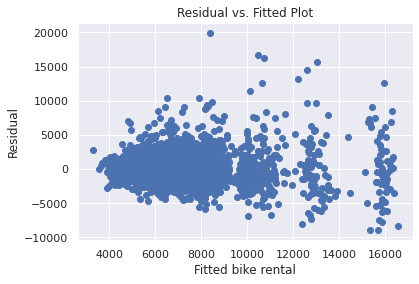

In [92]:
# plot 
plt.scatter(regression_model.fittedvalues, regression_model.resid)
# adding title and labels
plt.xlabel('lnpriceper')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot')
plt.show()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


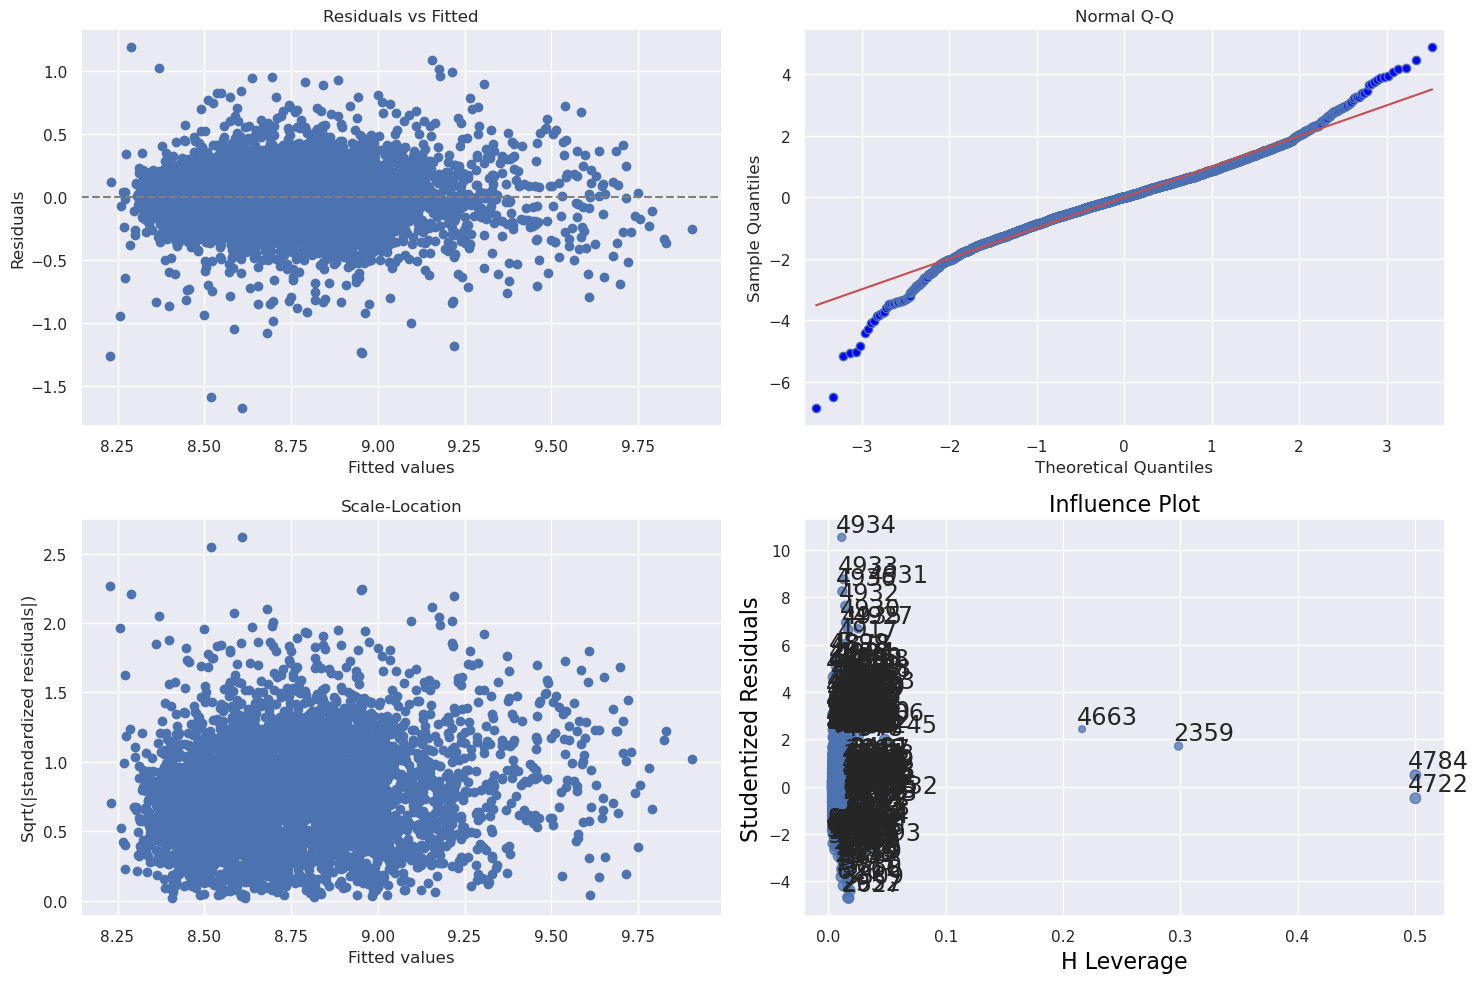

In [93]:
## plot
sns.set(font_scale=1)
fig = plt.figure(figsize = (15, 10), dpi = 100)
 
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(results['fitted'], results['resids'],  'o')
l = plt.axhline(y = 0, color = 'grey', linestyle = 'dashed')
ax1.set_xlabel('Fitted values')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Fitted')
 
ax2 = fig.add_subplot(2, 2, 2)
sm.qqplot(results['std_resids'], line='s', ax = ax2)
ax2.set_title('Normal Q-Q')
 
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(results['fitted'], abs(results['std_resids'])**.5,  'o')
ax3.set_xlabel('Fitted values')
ax3.set_ylabel('Sqrt(|standardized residuals|)')
ax3.set_title('Scale-Location')
 
ax4 = fig.add_subplot(2, 2, 4)
sns.set(font_scale=1)
sm.graphics.influence_plot(regression_model, criterion = 'Cooks', size = 0.5, ax = ax4)
 
plt.tight_layout()

In [72]:
t = df1.iloc[:,1:]
d = (t - t.min())/(t.max() - t.min())

In [73]:
d['lntfarea'] = np.log(df1.tfarea)
d['lnnumberrooms'] = np.log(df1.numberrooms)
d['lnclasst'] = np.log(df1.classt)
d['lnCURRENT_ENERGY_EFFICIENCY'] = np.log(df1.CURRENT_ENERGY_EFFICIENCY)
d['lnPOTENTIAL_ENERGY_EFFICIENCY'] = np.log(df1.POTENTIAL_ENERGY_EFFICIENCY)

In [74]:
X = d[['lntfarea', 'lnnumberrooms', 'lnclasst', 'lnCURRENT_ENERGY_EFFICIENCY',
       'lnPOTENTIAL_ENERGY_EFFICIENCY','duration_F', 'propertytype_D', 'propertytype_T','propertytype_F',
       'Area_name_Barnet', 'Area_name_Bexley',
       'Area_name_Brent', 'Area_name_Bromley', 'Area_name_Camden',
       'Area_name_City of London', 'Area_name_Croydon', 'Area_name_Ealing',
       'Area_name_Enfield', 'Area_name_Greenwich', 'Area_name_Hackney',
       'Area_name_Hammersmith and Fulham', 'Area_name_Haringey',
       'Area_name_Harrow', 'Area_name_Havering', 'Area_name_Hillingdon',
       'Area_name_Hounslow', 'Area_name_Islington',
       'Area_name_Kensington and Chelsea', 'Area_name_Kingston upon Thames',
       'Area_name_Lambeth', 'Area_name_Lewisham', 'Area_name_Merton',
       'Area_name_Newham', 'Area_name_Redbridge',
       'Area_name_Richmond upon Thames', 'Area_name_Southwark',
       'Area_name_Sutton', 'Area_name_Tower Hamlets',
       'Area_name_Waltham Forest', 'Area_name_Wandsworth',
       'Area_name_Westminster']]
regression_model = sm.OLS(endog= df1['lnpriceper'], exog=sm.add_constant(X)).fit()
regression_model.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             lnpriceper   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     138.5
Date:                Sat, 08 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:10:00   Log-Likelihood:                -26.857
No. Observations:                4938   AIC:                             137.7
Df Residuals:                    4896   BIC:                             410.9
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                9.5441      0.262     36.381      0.000       9.030      10.058
lntfarea                            -0.2357      0.016    -14.717      0.000      -0.267      -0.204
lnnumberrooms                        0.0342      0.018      1.902      0.057      -0.001       0.069
lnclasst                             0.2693      0.088      3.046      0.002       0.096       0.443
lnCURRENT_ENERGY_EFFICIENCY         -0.0290      0.018     -1.638      0.101      -0.064       0.006
lnPOTENTIAL_ENERGY_EFFICIENCY       -0.1755      0.039     -4.529      0.000      -0.251      -0.100
duration_F                           0.0800      0.028      2.898      0.004       0.026       0.134
propertytype_D                       0.1383      0.016      8.389      0.000       0.106       0.171
propertytype_T                      -0.0300      0.010     -3.006      0.003      -0.050      -0.010
propertytype_F                      -0.1290      0.028     -4.526      0.000      -0.185      -0.073
Area_name_Barnet                     0.4360      0.034     12.755      0.000       0.369       0.503
Area_name_Bexley                     0.0740      0.034      2.170      0.030       0.007       0.141
Area_name_Brent                      0.4720      0.040     11.694      0.000       0.393       0.551
Area_name_Bromley                    0.2523      0.032      7.773      0.000       0.189       0.316
Area_name_Camden                     1.0228      0.040     25.764      0.000       0.945       1.101
Area_name_City of London             1.1466      0.175      6.535      0.000       0.803       1.491
Area_name_Croydon                    0.1087      0.034      3.235      0.001       0.043       0.175
Area_name_Ealing                     0.5120      0.036     14.130      0.000       0.441       0.583
Area_name_Enfield                    0.2769      0.035      7.877      0.000       0.208       0.346
Area_name_Greenwich                  0.2990      0.036      8.379      0.000       0.229       0.369
Area_name_Hackney                    0.7078      0.042     16.668      0.000       0.625       0.791
Area_name_Hammersmith and Fulham     0.9151      0.039     23.339      0.000       0.838       0.992
Area_name_Haringey                   0.6615      0.036     18.181      0.000       0.590       0.733
Area_name_Harrow                     0.3031      0.038      7.954      0.000       0.228       0.378
Area_name_Havering                   0.1013      0.033      3.027      0.002       0.036       0.167
Area_name_Hillingdon                 0.2628      0.035      7.584      0.000       0.195       0.331
Area_name_Hounslow                   0.3192      0.037      8.593      0.000       0.246       0.392
Area_name_Islington                  0.9182      0.04

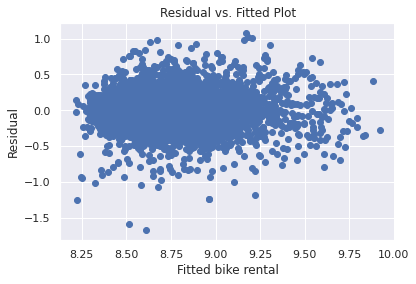

In [75]:
# plot 
plt.scatter(regression_model.fittedvalues, regression_model.resid)
# adding title and labels
plt.xlabel('lnpriceper')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot')
plt.show()

In [76]:
results = pd.DataFrame({'index': data.priceper,
                        'resids': regression_model.resid,
                        'std_resids': regression_model.resid_pearson,
                        'fitted': regression_model.fittedvalues
                       })
print(results.head()) 

         index    resids  std_resids    fitted
1  1024.390244 -1.580174   -6.467331  8.512026
2  1027.173913 -1.676241   -6.860517  8.610808
3  1061.946903 -1.255509   -5.138543  8.223368
7  1493.055556 -1.014285   -4.151262  8.322865
8  1500.000000 -0.932610   -3.816983  8.245830


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


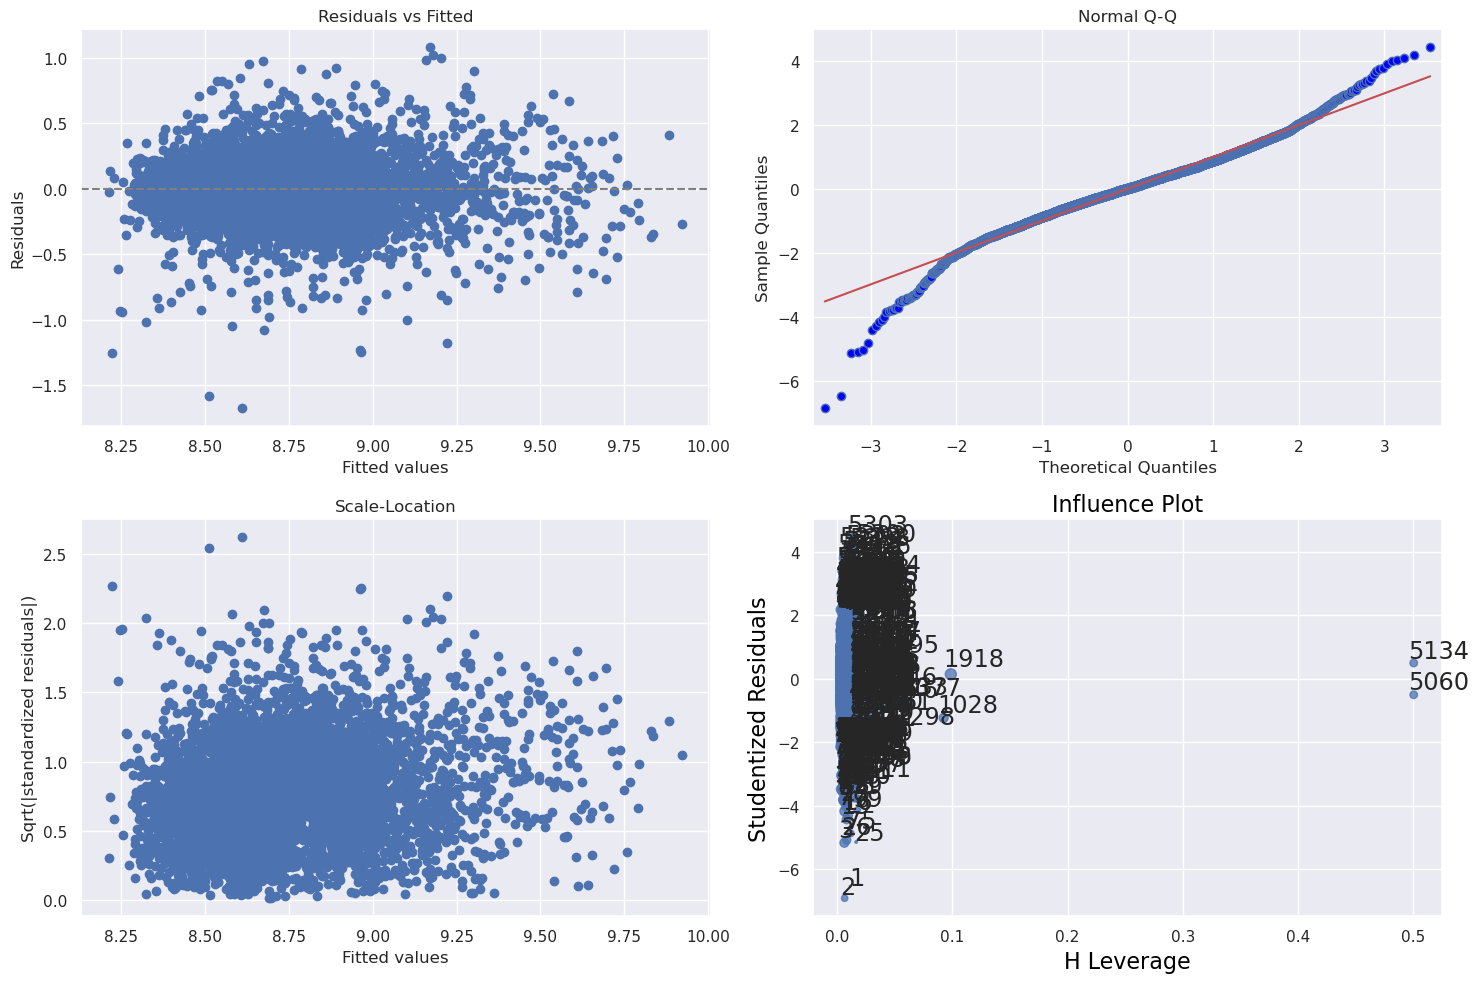

In [77]:
## plot
sns.set(font_scale=1)
fig = plt.figure(figsize = (15, 10), dpi = 100)
 
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(results['fitted'], results['resids'],  'o')
l = plt.axhline(y = 0, color = 'grey', linestyle = 'dashed')
ax1.set_xlabel('Fitted values')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Fitted')
 
ax2 = fig.add_subplot(2, 2, 2)
sm.qqplot(results['std_resids'], line='s', ax = ax2)
ax2.set_title('Normal Q-Q')
 
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(results['fitted'], abs(results['std_resids'])**.5,  'o')
ax3.set_xlabel('Fitted values')
ax3.set_ylabel('Sqrt(|standardized residuals|)')
ax3.set_title('Scale-Location')
 
ax4 = fig.add_subplot(2, 2, 4)
sns.set(font_scale=1)
sm.graphics.influence_plot(regression_model, criterion = 'Cooks', size = 0.5, ax = ax4)
 
plt.tight_layout()

In [78]:
outliers = regression_model.get_influence()
leverage = outliers.hat_matrix_diag
dffits = outliers.dffits[0]
resid_stu = outliers.resid_studentized_external
cook = outliers.cooks_distance[0]
contat1 = pd.concat([pd.Series(leverage,name = 'leverage'),pd.Series(dffits, name = 'dffits'),pd.Series(resid_stu, name = 'resid_stu'),pd.Series(cook, name = 'cook')],axis = 1)
data.index = range(data.shape[0])
profit_outliers = pd.concat([contat1],axis = 1)
pd.set_option('display.width',200)
pd.set_option('display.max.columns',None)
pd.set_option('display.max.rows',None)

In [79]:
data_drop = profit_outliers.query("cook>0.0008173273396")

In [117]:
df1 = data.drop(index=[0,1,2,3,5,6,16,17,19,40,51,55,71,76,87,88,91,98,104,114,174,175,189,190,210,250,
                             257,274,299,320,330,332,336,381,387,389,408,433,450,491,492,493,495,499,500,531,583,629,
                             647,671,677,691,726,729,760,787,793,807,810,811,813,814,815,816,825,829,830,844,965,982,983,969,1081,
                             1091,1093,1094,1098,1111,1143,1195,1212,1242,1255,1277,1297,1300,1304,1342,1347,1348,1353,1362,1384,1387,
                              1392,1398,1399,1437,1438,1446,1459,1492,1493,1496,1517,1557,1582,1593,1599,1602,1610,1611,1641,1670,1705,1717,1826,
                             1879,1884,1919,1922,1926,1927,1928,1930,1962,1979,2066,2129,2130,2174,2181,2207,2228,2252,2267,2272,2273,2274,2333,
                             2390,2391,2417,2444,2446,2477,2512,2548,2550,2574,2576,2632,2657,2662,2670,2682,2696,2747,2785,2797,2802,2828,2865,2867,2909,
                             2911,2939,2940,2941,2967,2983,3053,3054,3066,3073,3074,3075,3109,3114,3125,3126,3127,3130,3146,3161,3168,3227,3231,3248,3261,3288,
                             3291,3330,3369,3379,3409,3426,3446,3456,3486,3492,3535,3569,3580,3596,3646,3652,3658,3668,3685,3769,3786,3787,3792,3814,3816,3869,3870,3972,
                             3977,3985,3987,3996,4023,4040,4042,4073,4074,4079,4094,4096,4174,4180,4190,4199,4203,4247,4258,4268,4332,4333,4334,4335,4352,4417,4423,4425,4440,
                             4466,4467,4470,4498,4513,4539,4558,4578,4583,4616,4617,4621,4629,4646,4698,4699,4712,4728,4737,4739,4744,4761,4784,4803,4825,4829,4836,4841,4882,4891,4918,4937])

In [118]:
df1 = df1[['Area_name','priceper','propertytype','duration','tfarea',
          'numberrooms','classt','CURRENT_ENERGY_EFFICIENCY','POTENTIAL_ENERGY_EFFICIENCY']]

In [119]:
df1['lnpriceper'] = np.log(df1.priceper)

In [120]:
df1 = pd.get_dummies(df1)

In [121]:
df1['lnpriceper'] = np.log(df1.priceper)

In [122]:
t = df1.iloc[:,1:]
d = (t - t.min())/(t.max() - t.min())

In [123]:
df1['lntfarea'] = np.log(df1.tfarea)
df1['lnnumberrooms'] = np.log(df1.numberrooms)
df1['lnclasst'] = np.log(df1.classt)
df1['lnCURRENT_ENERGY_EFFICIENCY'] = np.log(df1.CURRENT_ENERGY_EFFICIENCY)
df1['lnPOTENTIAL_ENERGY_EFFICIENCY'] = np.log(df1.POTENTIAL_ENERGY_EFFICIENCY)

In [124]:
X = df1[['lntfarea', 'lnnumberrooms', 'lnclasst', 'lnCURRENT_ENERGY_EFFICIENCY','duration_F',
       'lnPOTENTIAL_ENERGY_EFFICIENCY', 'propertytype_D', 'propertytype_T','propertytype_F',
         'Area_name_Barnet', 'Area_name_Bexley',
       'Area_name_Brent', 'Area_name_Bromley', 'Area_name_Camden',
       'Area_name_Croydon', 'Area_name_Ealing',
       'Area_name_Enfield', 'Area_name_Greenwich', 'Area_name_Hackney',
       'Area_name_Hammersmith and Fulham', 'Area_name_Haringey',
       'Area_name_Harrow', 'Area_name_Havering', 'Area_name_Hillingdon',
       'Area_name_Hounslow', 'Area_name_Islington',
       'Area_name_Kensington and Chelsea', 'Area_name_Kingston upon Thames',
       'Area_name_Lambeth', 'Area_name_Lewisham', 'Area_name_Merton',
       'Area_name_Newham', 'Area_name_Redbridge',
       'Area_name_Richmond upon Thames', 'Area_name_Southwark',
       'Area_name_Sutton', 'Area_name_Tower Hamlets',
       'Area_name_Waltham Forest', 'Area_name_Wandsworth',
       'Area_name_Westminster']]
regression_model = sm.OLS(endog= df1['lnpriceper'], exog=sm.add_constant(X)).fit()
regression_model.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             lnpriceper   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     136.1
Date:                Sat, 08 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:32:11   Log-Likelihood:                 79.289
No. Observations:                4658   AIC:                            -76.58
Df Residuals:                    4617   BIC:                             187.7
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                9.5282      0.262     36.298      0.000       9.014      10.043
lntfarea                            -0.2099      0.016    -12.915      0.000      -0.242      -0.178
lnnumberrooms                        0.0194      0.018      1.068      0.285      -0.016       0.055
lnclasst                             0.2443      0.089      2.746      0.006       0.070       0.419
lnCURRENT_ENERGY_EFFICIENCY         -0.0246      0.020     -1.245      0.213      -0.063       0.014
duration_F                           0.0939      0.028      3.372      0.001       0.039       0.149
lnPOTENTIAL_ENERGY_EFFICIENCY       -0.1838      0.039     -4.684      0.000      -0.261      -0.107
propertytype_D                       0.1287      0.017      7.798      0.000       0.096       0.161
propertytype_T                      -0.0274      0.010     -2.732      0.006      -0.047      -0.008
propertytype_F                      -0.1086      0.029     -3.778      0.000      -0.165      -0.052
Area_name_Barnet                     0.4191      0.034     12.356      0.000       0.353       0.486
Area_name_Bexley                     0.0748      0.034      2.212      0.027       0.009       0.141
Area_name_Brent                      0.4611      0.040     11.420      0.000       0.382       0.540
Area_name_Bromley                    0.2428      0.032      7.564      0.000       0.180       0.306
Area_name_Camden                     0.9930      0.040     25.087      0.000       0.915       1.071
Area_name_Croydon                    0.0960      0.033      2.886      0.004       0.031       0.161
Area_name_Ealing                     0.4928      0.036     13.749      0.000       0.423       0.563
Area_name_Enfield                    0.2610      0.035      7.482      0.000       0.193       0.329
Area_name_Greenwich                  0.2858      0.035      8.067      0.000       0.216       0.355
Area_name_Hackney                    0.6999      0.043     16.376      0.000       0.616       0.784
Area_name_Hammersmith and Fulham     0.9067      0.040     22.852      0.000       0.829       0.984
Area_name_Haringey                   0.6509      0.036     18.019      0.000       0.580       0.722
Area_name_Harrow                     0.3009      0.038      7.928      0.000       0.227       0.375
Area_name_Havering                   0.0883      0.033      2.663      0.008       0.023       0.153
Area_name_Hillingdon                 0.2605      0.034      7.579      0.000       0.193       0.328
Area_name_Hounslow                   0.3030      0.037      8.233      0.000       0.231       0.375
Area_name_Islington                  0.9067      0.040     22.922      0.000       0.829       0.984
Area_name_Kensington and Chelsea     1.4032      0.04

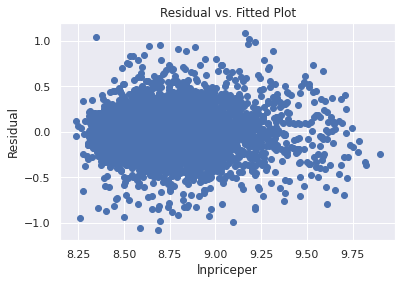

In [125]:
# plot 
plt.scatter(regression_model.fittedvalues, regression_model.resid)
# adding title and labels
plt.xlabel('lnpriceper')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot')
plt.show()

In [126]:
results = pd.DataFrame({'index': df1.priceper,
                        'resids': regression_model.resid,
                        'std_resids': regression_model.resid_pearson,
                        'fitted': regression_model.fittedvalues
                       })
print(results.head()) 

          index    resids  std_resids    fitted
4   1500.000000 -0.944703   -3.953714  8.257923
7   1854.545455 -0.833606   -3.488756  8.359000
8   1872.340426 -0.866822   -3.627771  8.401766
9   1875.000000 -1.053132   -4.407506  8.589496
10  1927.710843 -0.934523   -3.911110  8.498612


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


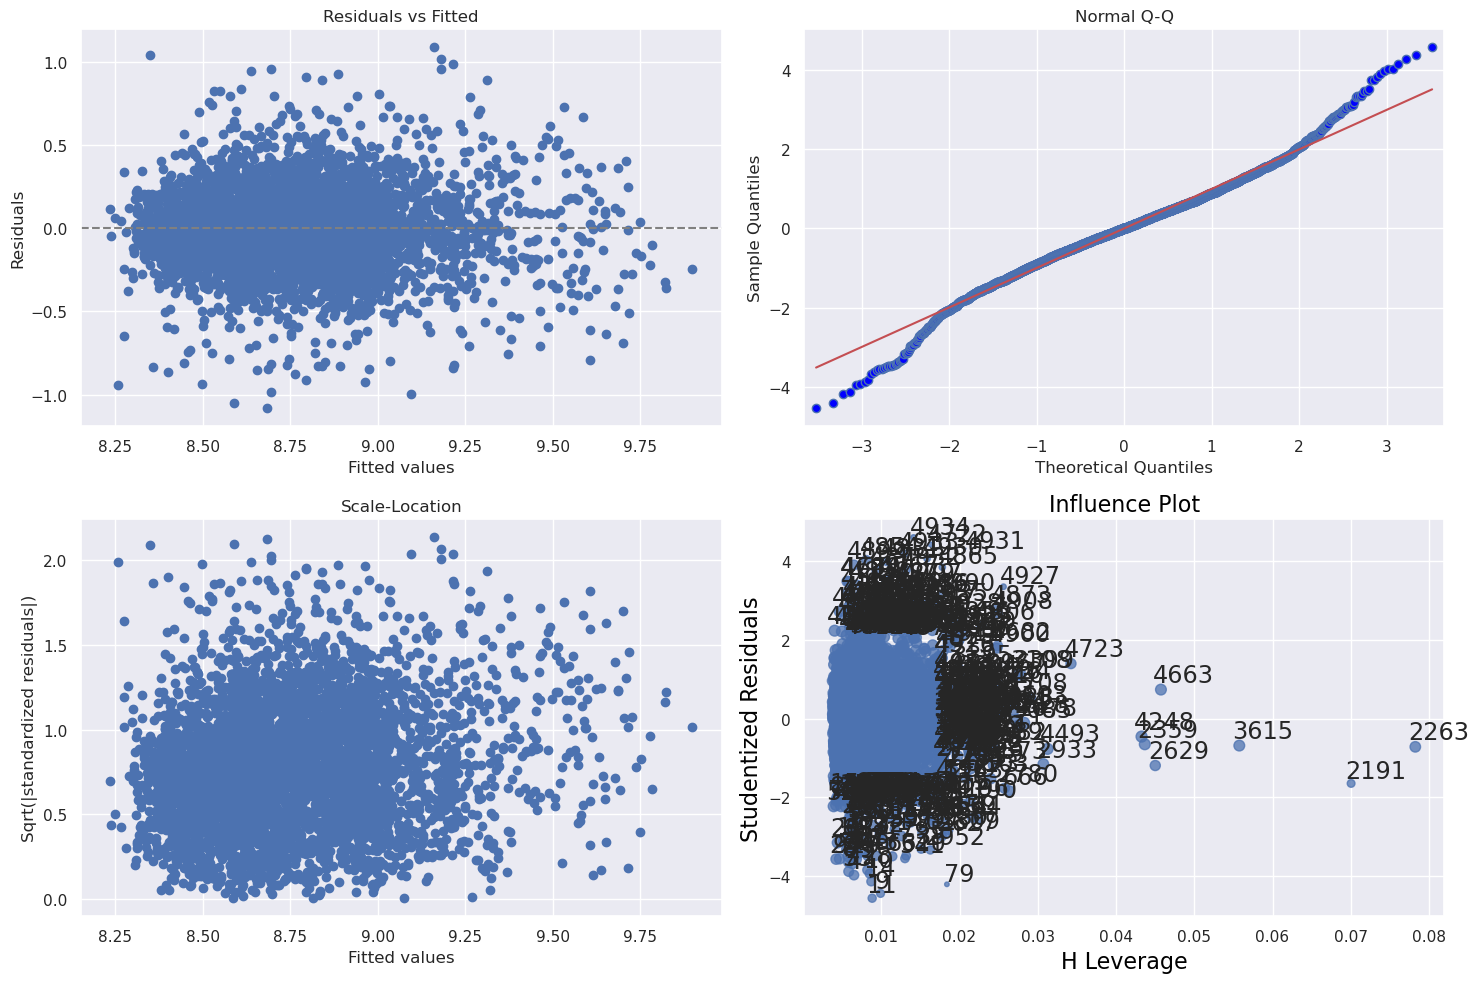

In [127]:
## plot
sns.set(font_scale=1)
fig = plt.figure(figsize = (15, 10), dpi = 100)
 
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(results['fitted'], results['resids'],  'o')
l = plt.axhline(y = 0, color = 'grey', linestyle = 'dashed')
ax1.set_xlabel('Fitted values')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Fitted')
 
ax2 = fig.add_subplot(2, 2, 2)
sm.qqplot(results['std_resids'], line='s', ax = ax2)
ax2.set_title('Normal Q-Q')
 
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(results['fitted'], abs(results['std_resids'])**.5,  'o')
ax3.set_xlabel('Fitted values')
ax3.set_ylabel('Sqrt(|standardized residuals|)')
ax3.set_title('Scale-Location')
 
ax4 = fig.add_subplot(2, 2, 4)
sns.set(font_scale=1)
sm.graphics.influence_plot(regression_model, criterion = 'Cooks', size = 0.5, ax = ax4)
 
plt.tight_layout()